#Evaluating YOLO11 and SSD Models for Object Detection in Drone Footage

---



In this notebook, we will begin by testing both the Single Shot Multibox Detector (SSD) and pretrained YOLO11 models on our custom dataset. We first evaluate SSD directly on our drone data without fine-tuning; however, initial results indicate poor object detection, leading us to prioritize YOLO for its superior performance in this context. 😊



In the next phase, we will further train YOLO using a labeled dataset from Roboflow to enhance accuracy and performance. Finally, we’ll evaluate the model post-training to assess improvements.













##SSD

In [1]:
import torch
from tqdm import tqdm
import cv2
import time
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opencv-python
!pip install torchvision
!pip install tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

video_path = '/content/drive/MyDrive/ExtractedFrames/parking - 12 sept, 12pm.MP4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


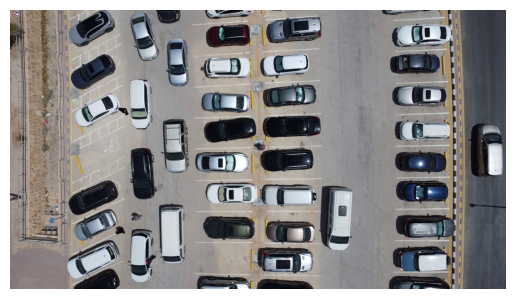

In [5]:

# Open the video from Google Drive
cap = cv2.VideoCapture(video_path)

# Check if the video is loaded correctly
if not cap.isOpened():
    print("Error opening video file")
else:
    # Example of reading a single frame
    ret, frame = cap.read()
    if ret:
        # Convert BGR (OpenCV format) to RGB (Matplotlib format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame using Matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Hide the axes
        plt.show()

cap.release()

### Load a pre-trained SSD model

In [6]:
import torch
from torchvision.models.detection import ssd300_vgg16

model = ssd300_vgg16(pretrained=True)
model.eval()

model = model.to('cuda')  # Move the model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 202MB/s]


These functions collaboratively handle the detection process: resizing frames to fit model requirements, performing detection, and then drawing bounding boxes on the detected objects for visual feedback.

In [7]:

# Function to preprocess frame
def preprocess_frame(frame):
    if frame is None or frame.size == 0:
        print("Error: Frame is empty, skipping resizing.")
        return None
    return cv2.resize(frame, (300, 300))

# Function to detect objects
def detect_objects(frame, model):
    if frame is None:
        print("Error: Empty frame passed to object detection.")
        return None

    # Convert frame (NumPy array) to a tensor and move to GPU
    frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float().unsqueeze(0).to('cuda')

    # Apply SSD model
    with torch.no_grad():
        predictions = model(frame_tensor)

    return predictions

# Function to visualize predictions
def visualize_predictions(frame, predictions, threshold=0.5):
    if frame is None or predictions is None:
        print("Error: Invalid frame or predictions.")
        return frame

    # Extract bounding boxes and labels
    boxes = predictions[0]['boxes'].detach().cpu().numpy()  # Move to CPU for visualization
    scores = predictions[0]['scores'].detach().cpu().numpy()

    for i in range(len(scores)):
        if scores[i] > threshold:
            box = boxes[i].astype(int)
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

    return frame


### Frame-by-Frame Object Detection

This block sequentially processes each frame, applies object detection, visualizes the results, and saves the output, while tracking progress and time per frame.

In [8]:

# Video processing loop
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
output_video = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (300, 300))

with tqdm(total=frame_count) as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Preprocess frame
        frame_preprocessed = preprocess_frame(frame)
        if frame_preprocessed is None:
            pbar.update(1)
            continue

        # Detect objects
        predictions = detect_objects(frame_preprocessed, model)

        # Visualize predictions
        frame_with_boxes = visualize_predictions(frame_preprocessed, predictions)

        # Write the processed frame to the output video
        output_video.write(frame_with_boxes)

        # Update progress bar
        pbar.update(1)

# Release resources
cap.release()
output_video.release()
cv2.destroyAllWindows()

  0%|          | 30/14343 [01:03<8:28:04,  2.13s/it]


##Pretrained YOLOv11n

In [1]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/225.8 GB disk)


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from ultralytics import YOLO
from IPython.display import Image as IPyImage

In [5]:
model = YOLO("yolo11n.pt")  # load a pretrained model

In [6]:
#No specific class is specified
results = model.predict(source="/content/drive/MyDrive/ExtractedFrames/ExtractedFrames/ExtractedFrames12PM/frame_10110.jpg", save=True)
results = model.predict(source="/content/drive/MyDrive/ExtractedFrames/ExtractedFrames/ExtractedFrames12PM/frame_14220.jpg", save=True)
results = model.predict(source="/content/drive/MyDrive/ExtractedFrames/ExtractedFrames/ExtractedFrames7AM/frame7am_21060.jpg", save=True)


image 1/1 /content/drive/MyDrive/ExtractedFrames/ExtractedFrames/ExtractedFrames12PM/frame_10110.jpg: 384x640 18 cell phones, 507.4ms
Speed: 17.1ms preprocess, 507.4ms inference, 30.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/ExtractedFrames/ExtractedFrames/ExtractedFrames12PM/frame_14220.jpg: 384x640 2 cars, 2 trucks, 212.3ms
Speed: 4.0ms preprocess, 212.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/ExtractedFrames/ExtractedFrames/ExtractedFrames7AM/frame7am_21060.jpg: 384x640 3 cars, 1 truck, 1 traffic light, 230.3ms
Speed: 4.0ms preprocess, 230.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


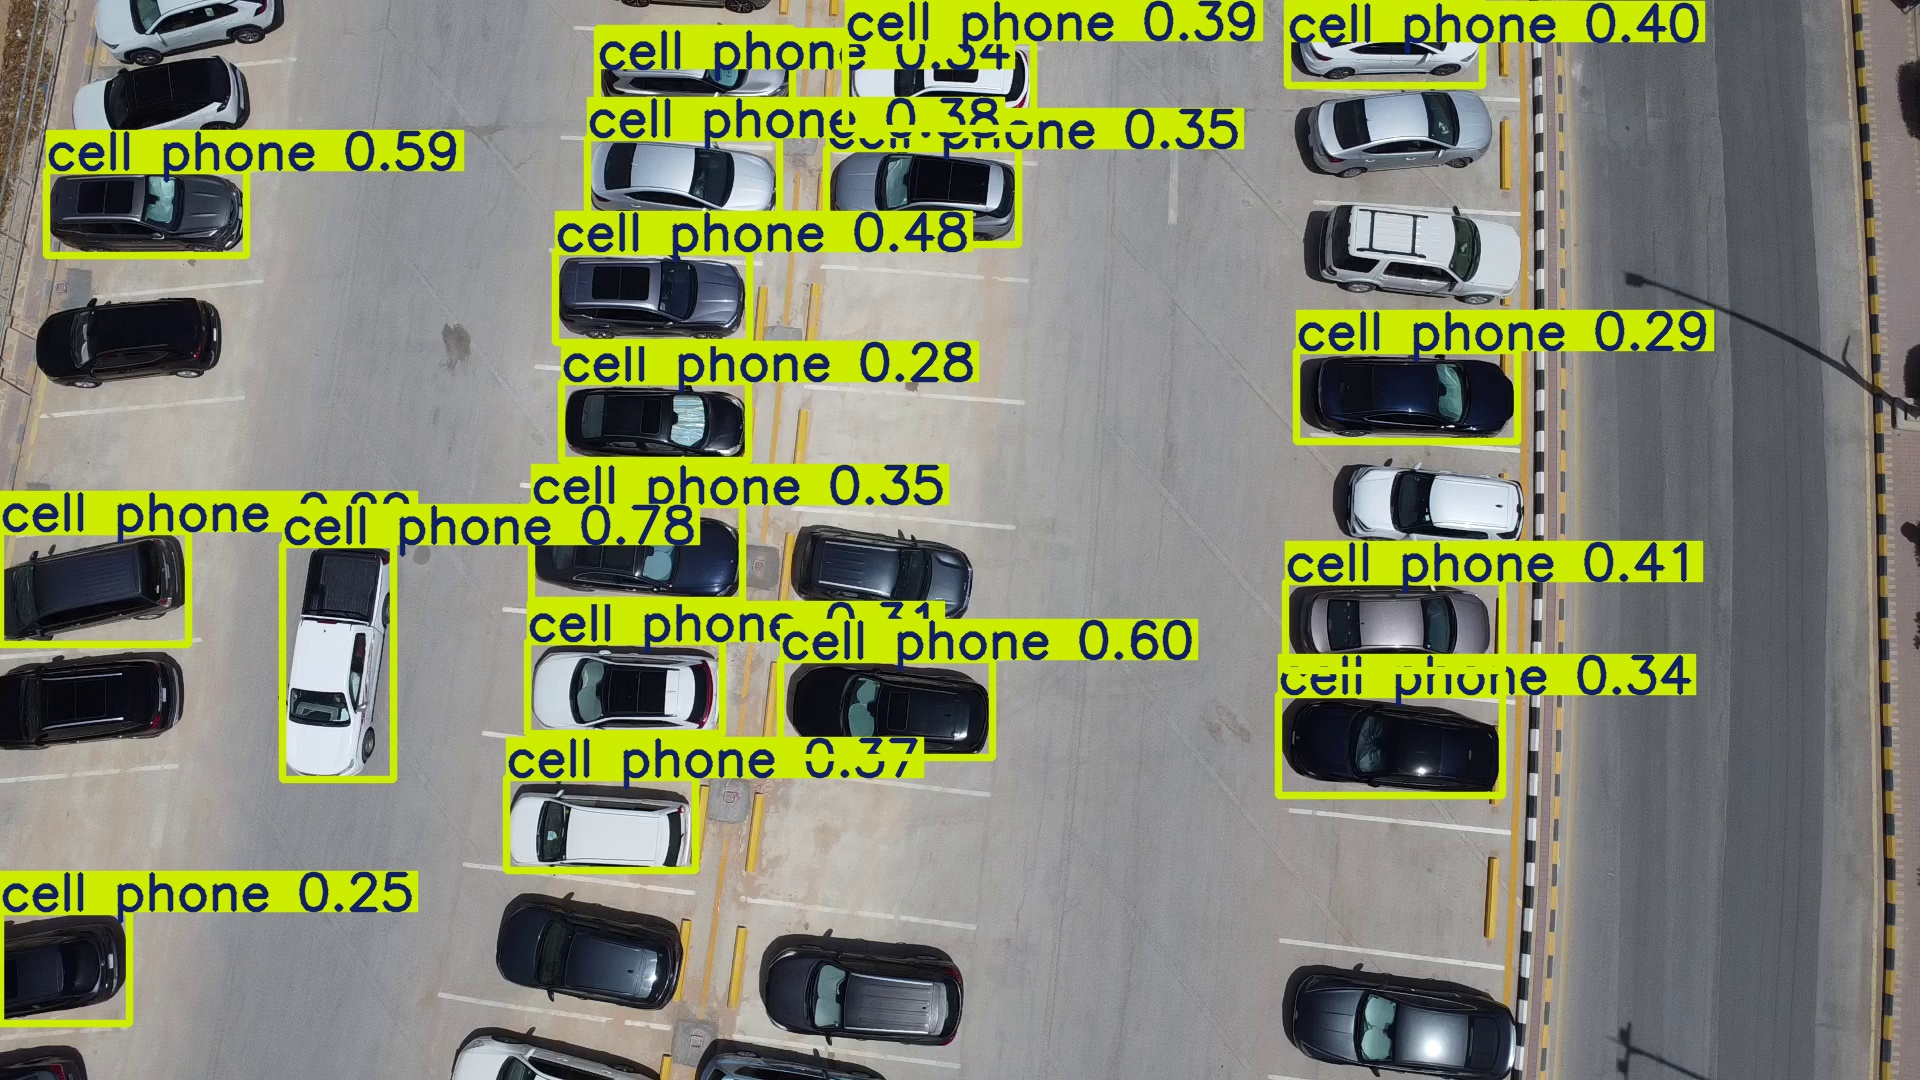

In [7]:
IPyImage(filename='/content/runs/detect/predict/frame_10110.jpg', width=600)

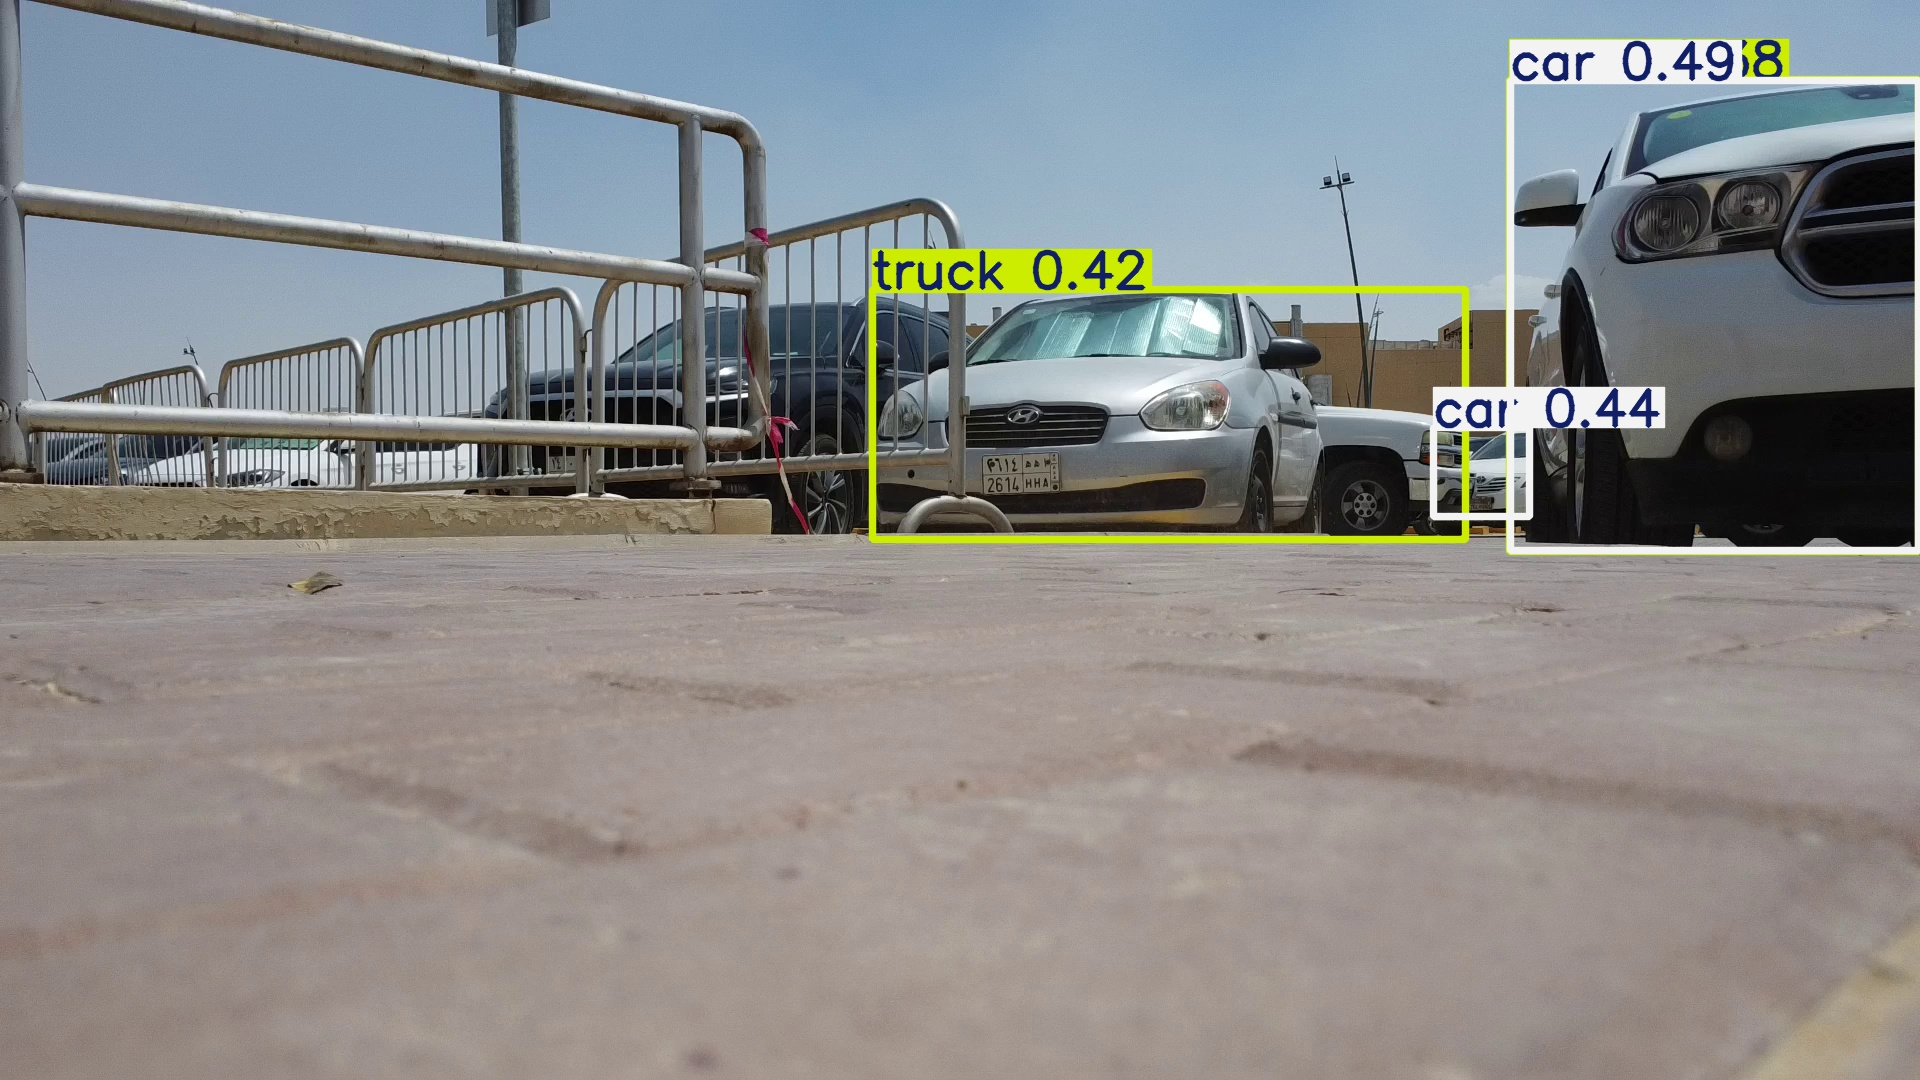

In [8]:
IPyImage(filename='/content/runs/detect/predict/frame_14220.jpg', width=600)

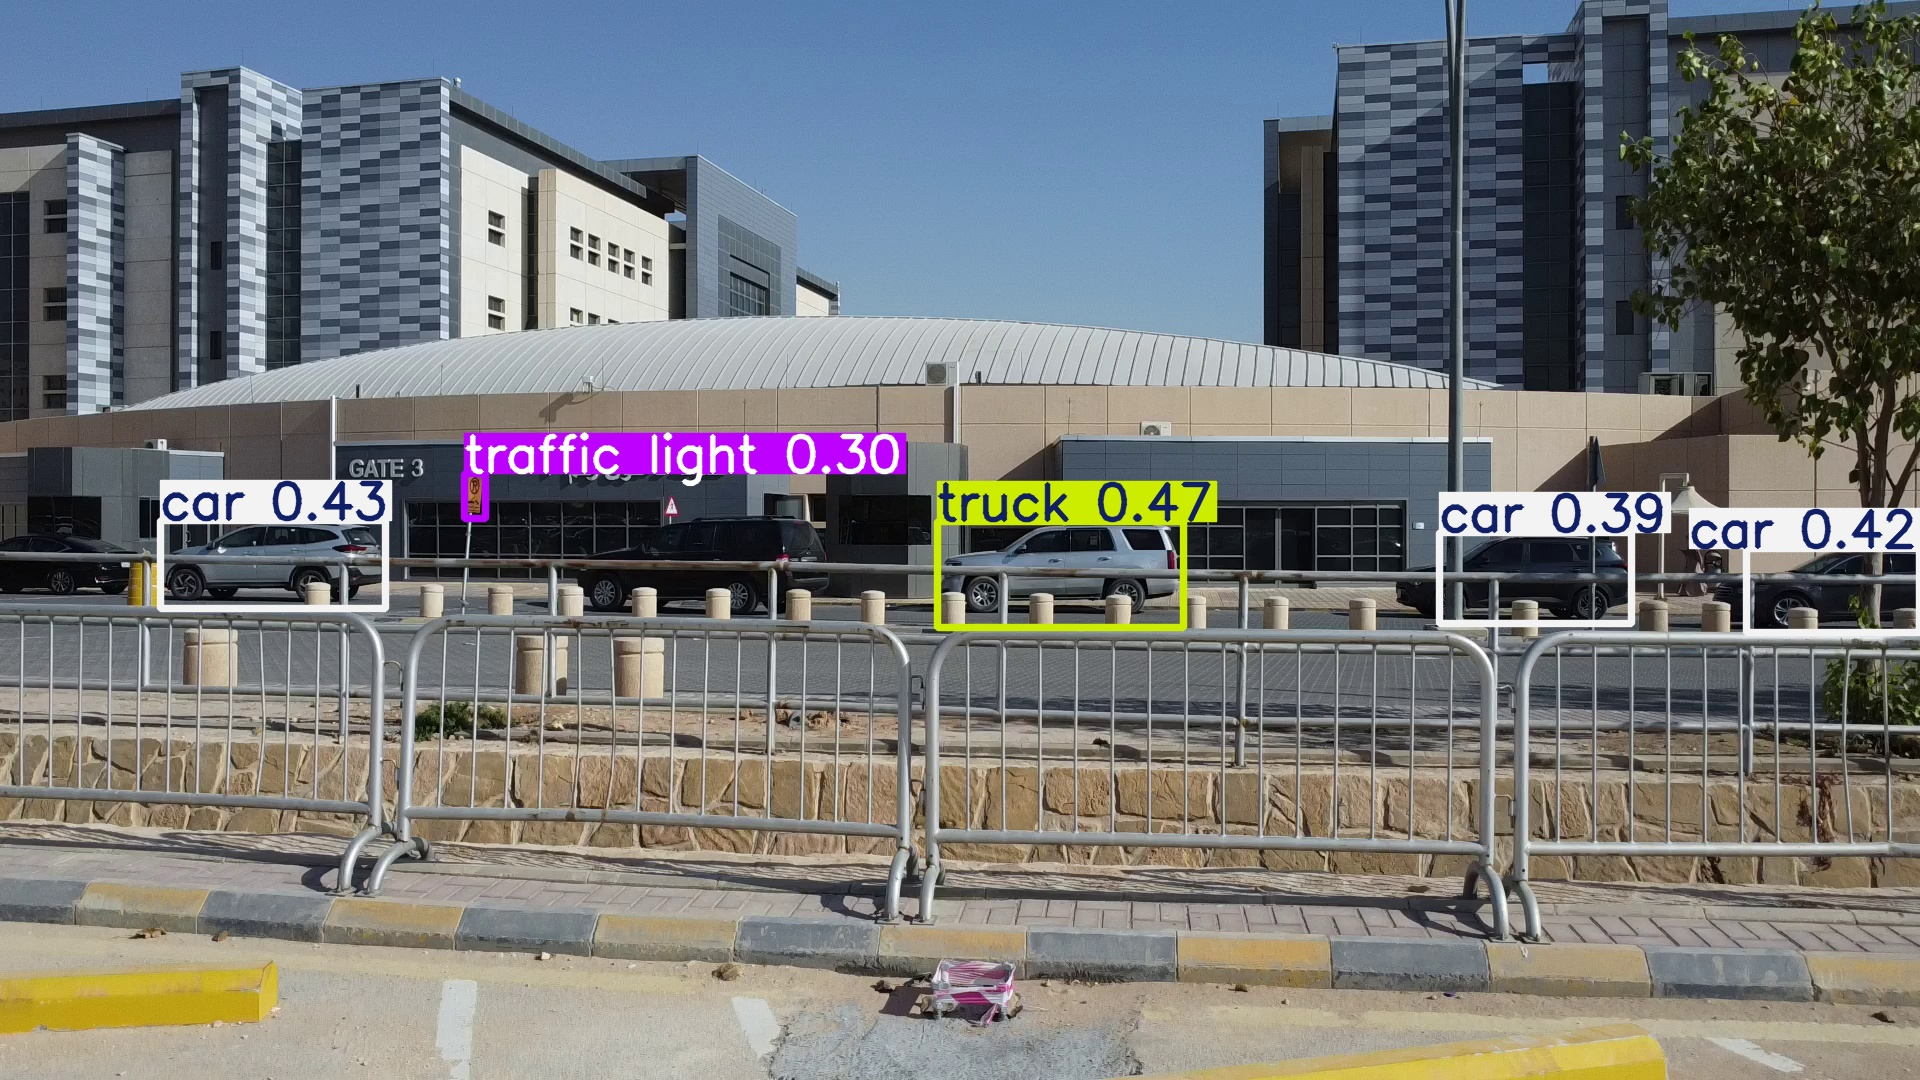

In [9]:
IPyImage(filename='/content/runs/detect/predict/frame7am_21060.jpg', width=600)

From the second and last frames displayed above, we observe that the pretrained YOLO11 model accurately detects cars when viewed from the front or side. However, it struggles with cars viewed from a top angle, which is the primary perspective in most frames of our dataset.

Interestingly, the model often misclassifies cars from a top view as the 'cellphone' class. This misclassification could actually help us later as we can leverage it to label our dataset more efficiently for further training or testing.

We imported YOLO11n with a confidence threshold of 0.25 to make predictions on selected frames. In the first prediction, the model detected all cars but misclassified them as cellphones. Testing with a frame at a different angle (front or side view) yielded better results, where the model correctly identified cars and trucks.

These results indicate that the model was not trained on top-angle images of cars, but primarily on front or side views.

## What is next?
We will focus on training YOLO11 specifically on top-angle car images, experimenting with different hyperparameters to enhance performance. Then, we’ll evaluate the model's accuracy and effectiveness on our dataset.








In [ ]:
# Citations and Acknowledgments

# @software{yolo11_ultralytics,
#   author = {Glenn Jocher and Jing Qiu},
#   title = {Ultralytics YOLO11},
#   version = {11.0.0},
#   year = {2024},
#   url = {https://github.com/ultralytics/ultralytics},
#   orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
#   license = {AGPL-3.0}
# }
